In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Num GPUs Available:  1


# 📌 Intro.
- [Kaggle의 Jellyfish 데이터셋](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types) 을 사용해 6종의 해파리를 분류하는 다중 분류기를 생성합니다.

# 데이터 로드 및 살펴보기

- 학습할 데이터셋을 불러와 데이터의 구성을 살펴봅니다.
- 데이터셋 링크의 설명을 보면 총 900장의 이미지에 6종의 Jellyfish에 대한 이미지들로 구성된 데이터 셋입니다.
- 다양한 해파리 종류로 구분되며, 종류에는 mauve stinger jellyfish, moon jellyfish, barrel jellyfish, blue jellyfish, compass jellyfish, lion’s mane jellyfish가 있습니다.

In [3]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder  # LabelEncoder를 사용하기 위해 임포트
from sklearn.model_selection import train_test_split  # train_test_split을 사용하기 위해 임포트
import os  # 파일 및 디렉토리 관리를 위해 임포트
import cv2  # OpenCV 라이브러리를 사용하기 위해 임포트
import numpy as np  # 배열 및 행렬 작업을 위해 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위해 임포트
import seaborn as sns  # 시각화를 위해 Seaborn 라이브러리 임포트

# 데이터 로드 함수 정의
def load_data(data_directory):
    images = []  # 이미지 데이터를 저장할 리스트
    labels = []  # 레이블 데이터를 저장할 리스트
    classes = []  # 클래스 목록을 저장할 리스트
    label_encoder = LabelEncoder()  # LabelEncoder 객체 생성

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):  # 디렉토리인 경우에만 처리
            classes.append(class_name)

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)  # 이미지 파일 읽기
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
                    img = cv2.resize(img, (224, 224))  # 크기 조정
                    img = img / 255.0  # 정규화
                    images.append(img)  # 이미지 리스트에 추가
                    labels.append(class_name)  # 레이블 리스트에 클래스 이름 추가

    images = np.array(images)  # 이미지 데이터를 NumPy 배열로 변환
    labels = label_encoder.fit_transform(labels)  # 레이블을 숫자로 변환
    classes = label_encoder.classes_  # 클래스 목록을 저장

    return images, labels, classes

# 훈련 데이터셋 로드
train_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train'
train_images, train_labels, train_classes = load_data(train_data_directory)

# 테스트 데이터셋 로드
test_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/test'
test_images, test_labels, test_classes = load_data(test_data_directory)

# 검증 데이터셋 로드
valid_data_directory = '/aiffel/aiffel/jellyfish/Train_Test_Valid/valid'
valid_images, valid_labels, valid_classes = load_data(valid_data_directory)

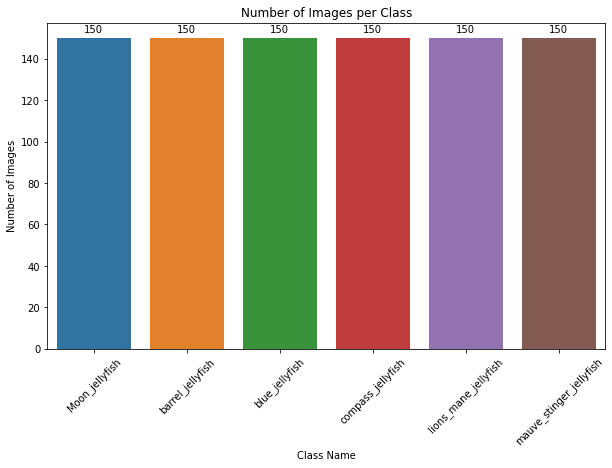

In [4]:
import pandas as pd

# 클래스별 이미지 개수 계산
class_counts = pd.Series(train_labels).value_counts().sort_index()
class_counts.index = train_classes  # 인덱스를 클래스 이름으로 변경

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=class_counts.index, y=class_counts.values)

# 각 막대에 숫자 표시
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

# 그래프 제목 및 레이블 설정
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

- 각 폴더 별로 모두 동일하게 150개씩 balanced한 데이터가 구성된 것을 알 수 있습니다.

In [5]:
# 훈련 데이터셋 이미지 shape 확인
print("훈련 데이터셋(train_images) 이미지의 shape:", train_images.shape)

# 테스트 데이터셋 이미지 shape 확인
print("테스트 데이터셋(test_images) 이미지의 shape:", test_images.shape)

# 검증 데이터셋 이미지 shape 확인
print("검증 데이터셋(valid_images) 이미지의 shape:", valid_images.shape)

훈련 데이터셋(train_images) 이미지의 shape: (900, 224, 224, 3)
테스트 데이터셋(test_images) 이미지의 shape: (40, 224, 224, 3)
검증 데이터셋(valid_images) 이미지의 shape: (39, 224, 224, 3)


- 전체 학습데이터는 900개, validation은 39개의 데이터로 구성된 것을 확인할 수 있습니다.
- 또한, 각 이미지의 shape는 모두 224 x 224 사이즈의 데이터 임을 확인할 수 있습니다.
- 각 클래스별 이미지를 출력해 보겠습니다.

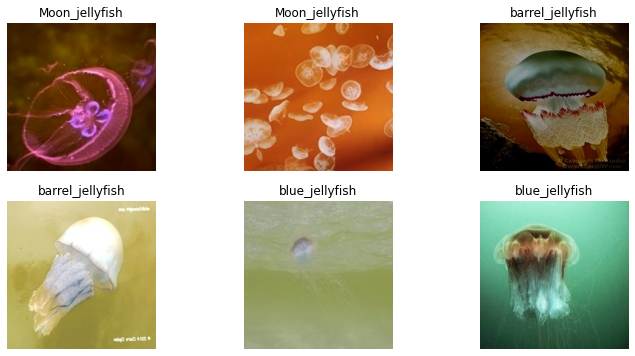

In [6]:
import random

# 클래스의 이름과 수를 파악합니다.
class_names = train_classes  # train_images에서 train_classes로 변경
num_classes = len(class_names)

# 1행: 클래스 별로 랜덤한 이미지 선택하여 출력
plt.figure(figsize=(12, 6))
for i in range(6):
    class_idx = i // 2  # 2개의 이미지를 1행에 출력하기 위해 클래스 인덱스 계산
    class_images = train_images[train_labels == class_idx]  # 해당 클래스의 이미지 가져오기
    random_index = random.randint(0, len(class_images) - 1)  # 랜덤한 이미지 인덱스 선택
    selected_image = class_images[random_index]

    # 이미지를 정규화 해제하여 BGR 색상으로 변환
    restored_image = selected_image * 255.0  # 정규화를 해제하기 위해 255를 곱합니다.
    restored_image = restored_image.astype("uint8")  # 정수형 데이터로 변환합니다.
    restored_image = cv2.cvtColor(restored_image, cv2.COLOR_RGB2BGR)  # RGB에서 BGR로 변환합니다.

    plt.subplot(2, 3, i + 1)
    plt.imshow(restored_image)
    plt.title(class_names[class_idx])  # 클래스 이름을 제목으로 표시
    plt.axis("off")

plt.show()

### 모델 학습(w. W&B 로깅)

In [7]:
import wandb
# wandb 로그인
wandb.login(key = "2d29f865a599e345b19afb8c9580dde83e64526d")

wandb: Currently logged in as: kimgabe (aiffel_dlthone_servings_3_like_4). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

## 모델링


- 가장 기본적인 CNN모델 구조부터 점진적으로 모델의 구조를 확장해 깊이를 깊게 만들면서 성능을 체크합니다.
- 이미 원본 데이터셋이 증강된 데이터이므로 첫 시도는 별도의 전처리 없이 
- 세부 하이퍼 파라미터의 튜닝은 W&B의 sweep기능을 통해 수행할 예정입니다.
- 각 모델의 성능 개선 과정을 W&B에 기록합니다.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# WandB 실행을 초기화하고 실험 이름을 지정합니다.
experiment_name = "CNN_V1-adam-20-0.001-gabe"
team_name = "3like4"
wandb.init(
    project= "Jellyfish_project",
    entity = team_name,
    name=experiment_name,  # 실험 이름을 설정합니다.
)

def CNN_V1():
    model = Sequential()

    # 첫 번째 convolution 레이어와 활성화 함수 추가
    model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224, 224, 3)))
    model.add(Activation('relu'))

    # 두 번째 convolution 레이어와 활성화 함수 추가
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # max pooling 레이어와 드롭아웃 레이어 추가
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # 세 번째 합성곱 레이어와 활성화 함수 추가
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # 두 번째 맥스 풀링 레이어와 드롭아웃 레이어 추가
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # flatten 레이어 추가
    model.add(Flatten())

    # 첫 번째 밀집 레이어와 활성화 함수 추가
    model.add(Dense(128))
    model.add(Activation('relu'))

    # 두 번째 dense 레이어와 활성화 함수 추가
    model.add(Dense(32))
    model.add(Activation('relu'))

    # 출력 레이어 추가
    model.add(Dense(6, activation='softmax'))

    return model

# 모델 선언
model = CNN_V1()

# 모델 요약
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 이미지 데이터 증강을 위한 데이터 제너레이터 생성
datagen = ImageDataGenerator(
    rotation_range=30,         # 이미지를 랜덤하게 30도 회전
    width_shift_range=0.1,     # 가로로 10%까지 랜덤하게 이동
    height_shift_range=0.1,    # 세로로 10%까지 랜덤하게 이동
    shear_range=0.1,           # 레이어를 변형
    zoom_range=0.3,            # 30% 범위로 확대 또는 축소
    horizontal_flip=True,      # 가로로 뒤집기
    vertical_flip=True,        # 세로로 뒤집기
)

datagen1 = ImageDataGenerator()

# 데이터 증강을 위한 데이터 제너레이터 생성
train_datagen = datagen.flow(train_images, train_labels, batch_size=20)
val_datagen = datagen1.flow(valid_images, valid_labels, batch_size=20)

wandb: Currently logged in as: kimgabe (3like4). Use `wandb login --relogin` to force relogin


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      1

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 조기 종료 콜백 정의
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V1.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[early_stopping_callback, model_checkpoint_callback])

# WandB에 로깅 정보 전송
wandb.log({"train_loss": history.history['loss'], "val_loss": history.history['val_loss'],
           "train_accuracy": history.history['accuracy'], "val_accuracy": history.history['val_accuracy']})

# WandB 실행을 마무리합니다.
wandb.finish()

Epoch 1/150
45/45 [==============================] - 13s 204ms/step - loss: 2.1601 - accuracy: 0.1978 - val_loss: 1.6306 - val_accuracy: 0.3590
Epoch 2/150
45/45 [==============================] - 9s 194ms/step - loss: 1.5634 - accuracy: 0.3278 - val_loss: 1.5158 - val_accuracy: 0.3077
Epoch 3/150
45/45 [==============================] - 9s 193ms/step - loss: 1.3700 - accuracy: 0.4722 - val_loss: 1.3982 - val_accuracy: 0.4872
Epoch 4/150
45/45 [==============================] - 9s 193ms/step - loss: 1.2958 - accuracy: 0.5033 - val_loss: 1.2938 - val_accuracy: 0.4359
Epoch 5/150
45/45 [==============================] - 9s 195ms/step - loss: 1.2223 - accuracy: 0.5089 - val_loss: 1.3368 - val_accuracy: 0.4615
Epoch 6/150
45/45 [==============================] - 9s 194ms/step - loss: 1.2068 - accuracy: 0.5033 - val_loss: 1.2674 - val_accuracy: 0.4615
Epoch 7/150
45/45 [==============================] - 9s 194ms/step - loss: 1.1415 - accuracy: 0.5567 - val_loss: 1.3090 - val_accuracy: 0.512

In [14]:
import seaborn as sns

def plot_accuracy_and_loss(history):
    # seaborn 스타일 설정
    sns.set(style="whitegrid")

    # Train 및 Val Accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Train 및 Val Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # 에포크 범위
    epochs_range = range(len(acc))

    # 그래프 크기 설정
    plt.figure(figsize=(12, 6))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Train Accuracy', color='blue')
    sns.lineplot(x=epochs_range, y=val_acc, label='Val Accuracy', color='red')
    plt.title('Train & Val Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Train Loss', color='blue')
    sns.lineplot(x=epochs_range, y=val_loss, label='Val Loss', color='red')
    plt.title('Train & Validation Loss')
    plt.legend()

    plt.show()

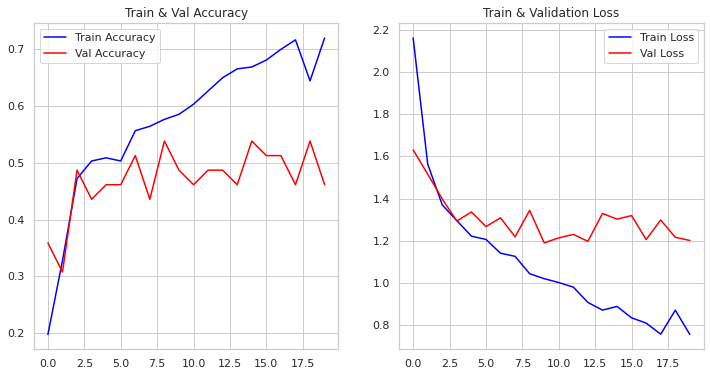

In [15]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

### 모델 평가 및 개선 방안 수립

- 전반적으로 검증 데이터에 대한 정확도가 훈련 데이터에 비해 현저히 낮아 과적합이 된 것으로 보여집니다.
- 모델 자체가 훈련데이터에는 적합한 것을 의미하므로, 과적합을 억제시킬 수 있다면 모델 성능을 일부 향상 시킬 수 있을 것으로 보여집니다.
- 현재 학습 추세를 보면 데이터수는 매우 적음에도 불구하고, 모델의 구조는 깊고 복잡해서 일반화 능력이 떨어지는 것이 주된 원인으로 보입니다.
- 훈련데이터를 더 늘려준다면 복잡한 모델에서도 성능향상을 기대할 수 있겠지만, 현재는 추가적인 데이터 확보가 쉽지 않은 상황입니다.
- 따라서 지금보다 더 작은 구조의 네트워크를 통해 학습을 시도해보는게 좋겠습니다.
- 다음과 같은 작업들을 적용해 모델을 개선해 보겠습니다.
    - 층수 감소 : convolution layer의 수를 줄여 모델을 간소화 합니다.
    - 필터 수 감소 : 각 convolution layer에서 필터의 수를 32개로 고정해 모델의 복잡도를 낮춥니다.
    - Dense layer의 노드 수 감소 : 첫번째 dense layer의 노드수는 128로, 두번째는 6으로 설정해 노드 수를 감소 시킵니다.
    - 각 합성곱 뒤에 레이어 정규화를 추가해 모델 안정화를 추구합니다.

In [12]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

model.save(f"best_model_epoch_{best_epoch}.h5")

Best Accuracy: 0.5767 at Epoch 9
Best Validation Accuracy: 0.5385 at Epoch 9


### W&B Sweep(하이퍼 파라미터 튜닝)

#### Sweep의 config를 설정

In [13]:
import wandb
from wandb.keras import WandbCallback

sweep_config = {
    "name": "CNN_V1-adam-20-0.001-gabe",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

def train():
    default_config = {
        "input" : (224, 224, 3),
        "num_classes" : 6,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config=default_config)
    config = wandb.config


    # 모델 생성 및 컴파일
    model = CNN_V1()
    model.compile(optimizer=config.optimizer,
                  loss=config.loss,
                  metrics=config.metrics)

    # 모델 학습
    model.fit(train_datagen, 
              epochs=config.epoch,
              validation_data=val_datagen,
              callbacks=[WandbCallback()])

    # 모델 평가
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

    # 결과 로깅
    wandb.log({"Test Accuracy": test_accuracy, "Test Loss": test_loss})

    
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "3like4",
                       project = "Jellyfish_project")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: tx6sb7dx
Sweep URL: https://wandb.ai/3like4/Jellyfish_project/sweeps/tx6sb7dx


wandb: Agent Starting Run: 2tgupha3 with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.05272736747039185


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
45/45 [==============================] - 9s 198ms/step - loss: 2.5456 - accuracy: 0.2556 - val_loss: 1.7569 - val_accuracy: 0.2308cy
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 5.1s


Epoch 2/10
45/45 [==============================] - 10s 203ms/step - loss: 1.5866 - accuracy: 0.3278 - val_loss: 1.4668 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 8.0s


Epoch 3/10
45/45 [==============================] - 9s 204ms/step - loss: 1.4285 - accuracy: 0.3989 - val_loss: 1.3824 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 8.3s


Epoch 4/10
45/45 [==============================] - 9s 201ms/step - loss: 1.3934 - accuracy: 0.4311 - val_loss: 1.3834 - val_accuracy: 0.4103
Epoch 5/10
45/45 [==============================] - 9s 193ms/step - loss: 1.3113 - accuracy: 0.4700 - val_loss: 1.3324 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 3.7s


Epoch 6/10
45/45 [==============================] - 9s 199ms/step - loss: 1.2865 - accuracy: 0.4622 - val_loss: 1.3468 - val_accuracy: 0.4615
Epoch 7/10
45/45 [==============================] - 9s 196ms/step - loss: 1.2140 - accuracy: 0.5100 - val_loss: 1.3038 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 3.6s


Epoch 8/10
45/45 [==============================] - 9s 198ms/step - loss: 1.2088 - accuracy: 0.5122 - val_loss: 1.3451 - val_accuracy: 0.4615
Epoch 9/10
45/45 [==============================] - 9s 195ms/step - loss: 1.1447 - accuracy: 0.5411 - val_loss: 1.3626 - val_accuracy: 0.5128
Epoch 10/10
45/45 [==============================] - 9s 197ms/step - loss: 1.1789 - accuracy: 0.5222 - val_loss: 1.2431 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_152910-2tgupha3/files/model-best)... Done. 3.7s


2/2 - 1s - loss: 1.1738 - accuracy: 0.5000


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▅▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▅▄▇▅▇█▅
val_loss,█▄▃▃▂▂▂▂▃▁
Test Accuracy,0.5
Test Loss,1.17382
accuracy,0.52222
best_epoch,9


wandb: Agent Starting Run: 97i18izu with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.056790656143314446


Epoch 1/5
45/45 [==============================] - 9s 197ms/step - loss: 2.7723 - accuracy: 0.2078 - val_loss: 1.6848 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best)... Done. 6.7s


Epoch 2/5
45/45 [==============================] - 9s 199ms/step - loss: 1.6463 - accuracy: 0.2756 - val_loss: 1.5772 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best)... Done. 4.8s


Epoch 3/5
45/45 [==============================] - 9s 204ms/step - loss: 1.5282 - accuracy: 0.3800 - val_loss: 1.4668 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best)... Done. 8.5s


Epoch 4/5
45/45 [==============================] - 9s 202ms/step - loss: 1.4759 - accuracy: 0.3889 - val_loss: 1.4638 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best)... Done. 8.5s


Epoch 5/5
45/45 [==============================] - 9s 203ms/step - loss: 1.3841 - accuracy: 0.4111 - val_loss: 1.3696 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153224-97i18izu/files/model-best)... Done. 8.3s


2/2 - 1s - loss: 1.3425 - accuracy: 0.4750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▇▇█
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▁█▅█
val_loss,█▆▃▃▁
Test Accuracy,0.475
Test Loss,1.3425
accuracy,0.41111
best_epoch,4


wandb: Agent Starting Run: xhml8gay with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.021080968238772493


Epoch 1/10
45/45 [==============================] - 10s 201ms/step - loss: 2.1959 - accuracy: 0.2489 - val_loss: 1.5108 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best)... Done. 6.5s


Epoch 2/10
45/45 [==============================] - 9s 202ms/step - loss: 1.5421 - accuracy: 0.3522 - val_loss: 1.3528 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best)... Done. 7.7s


Epoch 3/10
45/45 [==============================] - 9s 205ms/step - loss: 1.4346 - accuracy: 0.4056 - val_loss: 1.3648 - val_accuracy: 0.3333
Epoch 4/10
45/45 [==============================] - 9s 196ms/step - loss: 1.3563 - accuracy: 0.4800 - val_loss: 1.3069 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best)... Done. 8.4s


Epoch 5/10
45/45 [==============================] - 9s 206ms/step - loss: 1.2358 - accuracy: 0.4956 - val_loss: 1.1737 - val_accuracy: 0.5641
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153445-xhml8gay/files/model-best)... Done. 5.6s


Epoch 6/10
45/45 [==============================] - 9s 205ms/step - loss: 1.1933 - accuracy: 0.5056 - val_loss: 1.2775 - val_accuracy: 0.4872
Epoch 7/10
45/45 [==============================] - 9s 196ms/step - loss: 1.1226 - accuracy: 0.5633 - val_loss: 1.3622 - val_accuracy: 0.5128
Epoch 8/10
45/45 [==============================] - 9s 197ms/step - loss: 1.0705 - accuracy: 0.5622 - val_loss: 1.3527 - val_accuracy: 0.5385
Epoch 9/10
45/45 [==============================] - 9s 197ms/step - loss: 1.0884 - accuracy: 0.5722 - val_loss: 1.2233 - val_accuracy: 0.5897
Epoch 10/10
45/45 [==============================] - 9s 196ms/step - loss: 1.0158 - accuracy: 0.5767 - val_loss: 1.4099 - val_accuracy: 0.5641
2/2 - 0s - loss: 1.0860 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▄▆▆▆████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▃▁▇▇▅▆▇█▇
val_loss,█▅▅▄▁▃▅▅▂▆
Test Accuracy,0.55
Test Loss,1.086
accuracy,0.57667
best_epoch,4


wandb: Agent Starting Run: v5fm4uio with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.031501165238869186


Epoch 1/7
45/45 [==============================] - 10s 203ms/step - loss: 2.2029 - accuracy: 0.2167 - val_loss: 1.5664 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best)... Done. 9.2s


Epoch 2/7
45/45 [==============================] - 9s 203ms/step - loss: 1.4815 - accuracy: 0.3800 - val_loss: 1.3485 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best)... Done. 3.7s


Epoch 3/7
45/45 [==============================] - 9s 203ms/step - loss: 1.3290 - accuracy: 0.4600 - val_loss: 1.3418 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best)... Done. 4.7s


Epoch 4/7
45/45 [==============================] - 9s 203ms/step - loss: 1.3010 - accuracy: 0.4811 - val_loss: 1.2933 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153732-v5fm4uio/files/model-best)... Done. 7.8s


Epoch 5/7
45/45 [==============================] - 9s 207ms/step - loss: 1.2951 - accuracy: 0.4622 - val_loss: 1.4019 - val_accuracy: 0.4103
Epoch 6/7
45/45 [==============================] - 9s 198ms/step - loss: 1.1934 - accuracy: 0.5067 - val_loss: 1.3513 - val_accuracy: 0.3590
Epoch 7/7
45/45 [==============================] - 9s 196ms/step - loss: 1.2065 - accuracy: 0.5100 - val_loss: 1.4467 - val_accuracy: 0.3590
2/2 - 1s - loss: 1.2062 - accuracy: 0.5250


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▇▇▇██
epoch,▁▂▃▅▆▇█
loss,█▃▂▂▂▁▁
val_accuracy,▄▇█▇▄▁▁
val_loss,█▂▂▁▄▂▅
Test Accuracy,0.525
Test Loss,1.20623
accuracy,0.51
best_epoch,3


wandb: Agent Starting Run: wee2dc7p with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.061583828076957094


Epoch 1/10
45/45 [==============================] - 10s 200ms/step - loss: 2.2843 - accuracy: 0.2178 - val_loss: 1.5734 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 6.7s


Epoch 2/10
45/45 [==============================] - 9s 204ms/step - loss: 1.5553 - accuracy: 0.3767 - val_loss: 1.4420 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 5.1s


Epoch 3/10
45/45 [==============================] - 9s 204ms/step - loss: 1.3945 - accuracy: 0.4422 - val_loss: 1.3487 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 8.5s


Epoch 4/10
45/45 [==============================] - 9s 202ms/step - loss: 1.3418 - accuracy: 0.4589 - val_loss: 1.3214 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 8.0s


Epoch 5/10
45/45 [==============================] - 9s 205ms/step - loss: 1.2308 - accuracy: 0.4956 - val_loss: 1.3276 - val_accuracy: 0.5128
Epoch 6/10
45/45 [==============================] - 9s 199ms/step - loss: 1.1171 - accuracy: 0.5556 - val_loss: 1.3860 - val_accuracy: 0.4615
Epoch 7/10
45/45 [==============================] - 9s 193ms/step - loss: 1.1366 - accuracy: 0.5533 - val_loss: 1.2324 - val_accuracy: 0.5641
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 4.4s


Epoch 8/10
45/45 [==============================] - 9s 207ms/step - loss: 1.0599 - accuracy: 0.5878 - val_loss: 1.1959 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_153949-wee2dc7p/files/model-best)... Done. 5.4s


Epoch 9/10
45/45 [==============================] - 9s 203ms/step - loss: 1.0047 - accuracy: 0.6033 - val_loss: 1.2852 - val_accuracy: 0.4615
Epoch 10/10
45/45 [==============================] - 9s 194ms/step - loss: 1.0055 - accuracy: 0.6156 - val_loss: 1.3802 - val_accuracy: 0.5128
2/2 - 0s - loss: 1.1989 - accuracy: 0.4750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▂▄▅▅▃▆█▃▅
val_loss,█▆▄▃▃▅▂▁▃▄
Test Accuracy,0.475
Test Loss,1.1989
accuracy,0.61556
best_epoch,7


wandb: Agent Starting Run: o3ijydei with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.019141569731611345


Epoch 1/6
45/45 [==============================] - 10s 202ms/step - loss: 2.0847 - accuracy: 0.1922 - val_loss: 1.6988 - val_accuracy: 0.2308
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best)... Done. 6.8s


Epoch 2/6
45/45 [==============================] - 9s 205ms/step - loss: 1.5916 - accuracy: 0.3422 - val_loss: 1.4789 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best)... Done. 7.4s


Epoch 3/6
45/45 [==============================] - 9s 202ms/step - loss: 1.4074 - accuracy: 0.4367 - val_loss: 1.3507 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best)... Done. 4.8s


Epoch 4/6
45/45 [==============================] - 9s 204ms/step - loss: 1.2880 - accuracy: 0.4756 - val_loss: 1.3477 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best)... Done. 8.1s


Epoch 5/6
45/45 [==============================] - 9s 204ms/step - loss: 1.2461 - accuracy: 0.4922 - val_loss: 1.2819 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154253-o3ijydei/files/model-best)... Done. 4.8s


Epoch 6/6
45/45 [==============================] - 9s 205ms/step - loss: 1.1977 - accuracy: 0.5189 - val_loss: 1.3330 - val_accuracy: 0.4615
2/2 - 0s - loss: 1.1146 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▆▇▇█
epoch,▁▂▄▅▇█
loss,█▄▃▂▁▁
val_accuracy,▁▅▆█▆▆
val_loss,█▄▂▂▁▂
Test Accuracy,0.55
Test Loss,1.11458
accuracy,0.51889
best_epoch,4


wandb: Agent Starting Run: k4g5deq2 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.044519554313313905


Epoch 1/6
45/45 [==============================] - 9s 198ms/step - loss: 2.6899 - accuracy: 0.2711 - val_loss: 1.7161 - val_accuracy: 0.2564
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best)... Done. 7.2s


Epoch 2/6
45/45 [==============================] - 9s 204ms/step - loss: 1.5480 - accuracy: 0.3689 - val_loss: 1.3948 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best)... Done. 4.9s


Epoch 3/6
45/45 [==============================] - 9s 204ms/step - loss: 1.4465 - accuracy: 0.4178 - val_loss: 1.3219 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best)... Done. 8.3s


Epoch 4/6
45/45 [==============================] - 9s 201ms/step - loss: 1.2986 - accuracy: 0.4622 - val_loss: 1.3475 - val_accuracy: 0.4872
Epoch 5/6
45/45 [==============================] - 9s 197ms/step - loss: 1.2778 - accuracy: 0.4844 - val_loss: 1.2501 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best)... Done. 3.7s


Epoch 6/6
45/45 [==============================] - 9s 204ms/step - loss: 1.2481 - accuracy: 0.5022 - val_loss: 1.2172 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154511-k4g5deq2/files/model-best)... Done. 8.3s


2/2 - 0s - loss: 1.2031 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▇▇█
epoch,▁▂▄▅▇█
loss,█▂▂▁▁▁
val_accuracy,▁▇▅▇██
val_loss,█▃▂▃▁▁
Test Accuracy,0.575
Test Loss,1.20313
accuracy,0.50222
best_epoch,5


wandb: Agent Starting Run: 53tdteee with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.06090643880940356


Epoch 1/10
45/45 [==============================] - 10s 200ms/step - loss: 2.8010 - accuracy: 0.2389 - val_loss: 1.7575 - val_accuracy: 0.2564
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 9.3s


Epoch 2/10
45/45 [==============================] - 9s 203ms/step - loss: 1.6629 - accuracy: 0.3022 - val_loss: 1.6117 - val_accuracy: 0.3333
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 7.9s


Epoch 3/10
45/45 [==============================] - 9s 202ms/step - loss: 1.5508 - accuracy: 0.3456 - val_loss: 1.5704 - val_accuracy: 0.2564
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 6.7s


Epoch 4/10
45/45 [==============================] - 9s 203ms/step - loss: 1.4799 - accuracy: 0.3811 - val_loss: 1.4476 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 8.1s


Epoch 5/10
45/45 [==============================] - 9s 205ms/step - loss: 1.4079 - accuracy: 0.4422 - val_loss: 1.4003 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 8.1s


Epoch 6/10
45/45 [==============================] - 9s 196ms/step - loss: 1.3975 - accuracy: 0.4444 - val_loss: 1.4595 - val_accuracy: 0.3846
Epoch 7/10
45/45 [==============================] - 9s 197ms/step - loss: 1.3177 - accuracy: 0.4600 - val_loss: 1.4222 - val_accuracy: 0.4615
Epoch 8/10
45/45 [==============================] - 9s 197ms/step - loss: 1.2773 - accuracy: 0.4722 - val_loss: 1.3123 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 3.6s


Epoch 9/10
45/45 [==============================] - 9s 203ms/step - loss: 1.2976 - accuracy: 0.4800 - val_loss: 1.3687 - val_accuracy: 0.4103
Epoch 10/10
45/45 [==============================] - 9s 196ms/step - loss: 1.1893 - accuracy: 0.5267 - val_loss: 1.2256 - val_accuracy: 0.4615
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_154727-53tdteee/files/model-best)... Done. 8.3s


2/2 - 1s - loss: 1.1761 - accuracy: 0.4750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▄▄▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▁▅▆▅▇█▆▇
val_loss,█▆▆▄▃▄▄▂▃▁
Test Accuracy,0.475
Test Loss,1.17608
accuracy,0.52667
best_epoch,9


wandb: Agent Starting Run: svt0f36l with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.018746545439432247


Epoch 1/10
45/45 [==============================] - 10s 198ms/step - loss: 2.4423 - accuracy: 0.2289 - val_loss: 1.7121 - val_accuracy: 0.2821
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best)... Done. 8.5s


Epoch 2/10
45/45 [==============================] - 9s 200ms/step - loss: 1.6525 - accuracy: 0.2911 - val_loss: 1.4586 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best)... Done. 8.1s


Epoch 3/10
45/45 [==============================] - 9s 201ms/step - loss: 1.5218 - accuracy: 0.3733 - val_loss: 1.4859 - val_accuracy: 0.3846
Epoch 4/10
45/45 [==============================] - 9s 199ms/step - loss: 1.3745 - accuracy: 0.4567 - val_loss: 1.5655 - val_accuracy: 0.3333
Epoch 5/10
45/45 [==============================] - 9s 196ms/step - loss: 1.2668 - accuracy: 0.4856 - val_loss: 1.2865 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best)... Done. 4.9s


Epoch 6/10
45/45 [==============================] - 9s 203ms/step - loss: 1.2429 - accuracy: 0.5089 - val_loss: 1.3345 - val_accuracy: 0.4359
Epoch 7/10
45/45 [==============================] - 9s 201ms/step - loss: 1.2099 - accuracy: 0.5233 - val_loss: 1.3308 - val_accuracy: 0.4615
Epoch 8/10
45/45 [==============================] - 9s 195ms/step - loss: 1.2051 - accuracy: 0.5200 - val_loss: 1.1946 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155121-svt0f36l/files/model-best)... Done. 4.7s


Epoch 9/10
45/45 [==============================] - 9s 204ms/step - loss: 1.1032 - accuracy: 0.5633 - val_loss: 1.3504 - val_accuracy: 0.4872
Epoch 10/10
45/45 [==============================] - 9s 201ms/step - loss: 1.0919 - accuracy: 0.5689 - val_loss: 1.3078 - val_accuracy: 0.4359
2/2 - 1s - loss: 1.1243 - accuracy: 0.5250


Test Accuracy,▁
Test Loss,▁
accuracy,▁▂▄▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▂▁▁
val_accuracy,▁▃▃▂▆▄▅█▅▄
val_loss,█▅▅▆▂▃▃▁▃▃
Test Accuracy,0.525
Test Loss,1.12432
accuracy,0.56889
best_epoch,7


wandb: Agent Starting Run: x8dgv6jf with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.004648103220862501


Epoch 1/6
45/45 [==============================] - 10s 201ms/step - loss: 2.2056 - accuracy: 0.2400 - val_loss: 1.6290 - val_accuracy: 0.3590
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 9.0s


Epoch 2/6
45/45 [==============================] - 9s 203ms/step - loss: 1.5644 - accuracy: 0.3533 - val_loss: 1.5002 - val_accuracy: 0.4103
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 8.2s


Epoch 3/6
45/45 [==============================] - 9s 205ms/step - loss: 1.4795 - accuracy: 0.4167 - val_loss: 1.3676 - val_accuracy: 0.4359
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 5.6s


Epoch 4/6
45/45 [==============================] - 9s 200ms/step - loss: 1.4624 - accuracy: 0.4244 - val_loss: 1.3638 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 7.3s


Epoch 5/6
45/45 [==============================] - 9s 202ms/step - loss: 1.4099 - accuracy: 0.4133 - val_loss: 1.3435 - val_accuracy: 0.3846
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 4.6s


Epoch 6/6
45/45 [==============================] - 9s 204ms/step - loss: 1.3510 - accuracy: 0.4456 - val_loss: 1.1870 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_155405-x8dgv6jf/files/model-best)... Done. 8.5s


2/2 - 0s - loss: 1.1842 - accuracy: 0.5250


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▇▇▇█
epoch,▁▂▄▅▇█
loss,█▃▂▂▁▁
val_accuracy,▁▃▄▂▂█
val_loss,█▆▄▄▃▁
Test Accuracy,0.525
Test Loss,1.18419
accuracy,0.44556
best_epoch,5


## CNN_V2 (모델간소화)

In [23]:
# 실험 정보 설정
model_name = "CNN_V2"
optimizer_name = "adam"
batch_size = 20
learning_rate = 0.001
experiment_name = model_name + "-" + optimizer_name + "-" + str(batch_size) + "-" + str(learning_rate) + "-gabe"

# 팀명 설정
team_name = "3like4"

# WandB 실행 초기화 및 실험 이름 설정
wandb.init(
    project="Jellyfish_project",
    entity=team_name,
    name=experiment_name,
)

def CNN_V2():
    # Sequential 모델 정의
    model = tf.keras.models.Sequential([
        # 첫 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 두 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 두 번째 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 세 번째 합성곱 레이어: 32개의 필터, 3x3 크기의 커널, 활성화 함수 ReLU
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),

        # 레이어 정규화 추가
        tf.keras.layers.LayerNormalization(),

        # 세 번째 맥스 풀링 레이어: 4x4 크기의 풀링
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 데이터를 1차원으로 펼치는 레이어
        tf.keras.layers.Flatten(),

        # 첫 번째 밀집 레이어: 128개의 뉴런, 활성화 함수 ReLU
        tf.keras.layers.Dense(128, activation='relu'),

        # 출력 레이어: 클래스 수에 맞춰 6개의 뉴런, 활성화 함수 Softmax
        tf.keras.layers.Dense(6, activation='softmax')  
        ])
    
    return model

# 모델 선언
CNN_V2_model = CNN_V2()
    
# 모델 요약
CNN_V2_model.summary()


# 모델 컴파일
CNN_V2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
layer_normalization_9 (Layer (None, 224, 224, 32)      64        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
layer_normalization_10 (Laye (None, 56, 56, 32)        64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)       

### 모델 학습

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 조기 종료 콜백 정의
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V2.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V2_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[early_stopping_callback, model_checkpoint_callback])

# WandB에 로깅 정보 전송
wandb.log({"train_loss": history.history['loss'], "val_loss": history.history['val_loss'],
           "train_accuracy": history.history['accuracy'], "val_accuracy": history.history['val_accuracy']})

# WandB 실행을 마무리합니다.
wandb.finish()

Epoch 1/150
45/45 [==============================] - 12s 207ms/step - loss: 1.8170 - accuracy: 0.2722 - val_loss: 1.4813 - val_accuracy: 0.3590
Epoch 2/150
45/45 [==============================] - 9s 204ms/step - loss: 1.5420 - accuracy: 0.3589 - val_loss: 1.3168 - val_accuracy: 0.4359
Epoch 3/150
45/45 [==============================] - 9s 203ms/step - loss: 1.3888 - accuracy: 0.4500 - val_loss: 1.2132 - val_accuracy: 0.4872
Epoch 4/150
45/45 [==============================] - 9s 202ms/step - loss: 1.3498 - accuracy: 0.4333 - val_loss: 1.1618 - val_accuracy: 0.5897
Epoch 5/150
45/45 [==============================] - 9s 206ms/step - loss: 1.2264 - accuracy: 0.5111 - val_loss: 1.1647 - val_accuracy: 0.4615
Epoch 6/150
45/45 [==============================] - 9s 200ms/step - loss: 1.1611 - accuracy: 0.5411 - val_loss: 1.3595 - val_accuracy: 0.4615
Epoch 7/150
45/45 [==============================] - 9s 203ms/step - loss: 1.1271 - accuracy: 0.5611 - val_loss: 1.2064 - val_accuracy: 0.435

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

Best Accuracy: 0.6544 at Epoch 12
Best Validation Accuracy: 0.6410 at Epoch 12


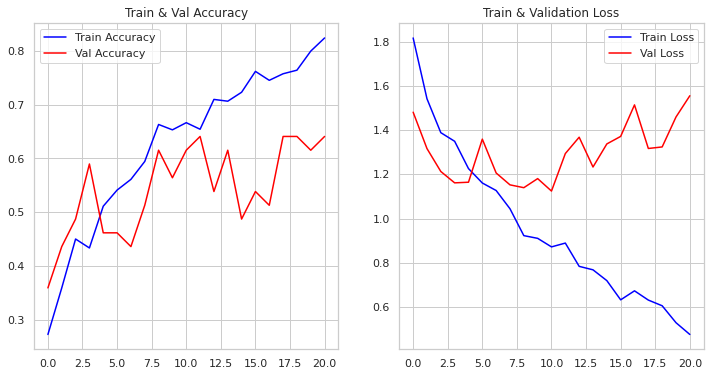

In [26]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

### 모델 평가 및 개선 방안 수립

- 학습/검증 정확도는 이전모델보다 성능이 향상되었습니다. 다만 초기 epoch에 최고성능에 도달한 뒤, 지속적으로 성능이 악화되고 있습니다.
- 이전 모델보다는 일반화 성능이 좋아진 모델임은 맞지만, 아직까지도 과적합이 발생하는 것으로 보여집니다.
- 모델 구조적 측면의 개선을 위해 아래의 방법들을 시도해 보겠습니다.
    - 드롭아웃 추가 : 각 convolution layer 후에 드롭아웃을 추가해 과적합을 억제 시킵니다.
    - 필터 수 조정 : 모델 복잡성을 감소 시킵니다.
    - 맥스 풀링 크기 축소 : 2 x 2 로 크기를 조절해서, 특성 맵의 크기를 너무 빠르게 줄이지 않도록 수정합니다.
    - Global Average Pooling 적용 : Flatten 대신 사용하여 파라미터수를 줄이고 과적합을 방지할 수 있습니다.

In [27]:
import wandb
from wandb.keras import WandbCallback


sweep_config = {
    "name": experiment_name,
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

def train():
    default_config = {
        "input" : (224, 224, 3),
        "num_classes" : 6,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config=default_config)
    config = wandb.config


    # 모델 생성 및 컴파일
    CNN_V2_model = CNN_V2()
    CNN_V2_model.compile(optimizer=config.optimizer,
                  loss=config.loss,
                  metrics=config.metrics)

    # 모델 학습
    model.fit(train_datagen, 
              epochs=config.epoch,
              validation_data=val_datagen,
              callbacks=[WandbCallback()])

    # 모델 평가
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

    # 결과 로깅
    wandb.log({"Test Accuracy": test_accuracy, "Test Loss": test_loss})

    
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "3like4",
                       project = "Jellyfish_project")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: haqkrcc0
Sweep URL: https://wandb.ai/3like4/Jellyfish_project/sweeps/haqkrcc0


wandb: Agent Starting Run: 8uxg6o0v with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.0778235231103807


Epoch 1/7
45/45 [==============================] - 9s 200ms/step - loss: 1.0341 - accuracy: 0.5867 - val_loss: 1.1784 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160352-8uxg6o0v/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160352-8uxg6o0v/files/model-best)... Done. 9.9s


Epoch 2/7
45/45 [==============================] - 9s 205ms/step - loss: 0.8934 - accuracy: 0.6489 - val_loss: 1.3883 - val_accuracy: 0.4359
Epoch 3/7
45/45 [==============================] - 9s 200ms/step - loss: 0.9250 - accuracy: 0.6433 - val_loss: 1.3385 - val_accuracy: 0.4872 - los
Epoch 4/7
45/45 [==============================] - 9s 197ms/step - loss: 0.8995 - accuracy: 0.6444 - val_loss: 1.2843 - val_accuracy: 0.4872
Epoch 5/7
45/45 [==============================] - 9s 196ms/step - loss: 0.8414 - accuracy: 0.6811 - val_loss: 1.1909 - val_accuracy: 0.5128
Epoch 6/7
45/45 [==============================] - 9s 196ms/step - loss: 0.8400 - accuracy: 0.6856 - val_loss: 1.4144 - val_accuracy: 0.4872
Epoch 7/7
45/45 [==============================] - 9s 198ms/step - loss: 0.8388 - accuracy: 0.6867 - val_loss: 1.4479 - val_accuracy: 0.5385.8467 - accu
2/2 - 0s - loss: 1.2588 - accuracy: 0.5500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▅▅███
epoch,▁▂▃▅▆▇█
loss,█▃▄▃▁▁▁
val_accuracy,▄▁▄▄▆▄█
val_loss,▁▆▅▄▁▇█
Test Accuracy,0.55
Test Loss,1.25877
accuracy,0.68667
best_epoch,0


wandb: Agent Starting Run: s6iivrfl with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.0237417271453808


Epoch 1/7
45/45 [==============================] - 9s 196ms/step - loss: 0.8080 - accuracy: 0.6900 - val_loss: 1.1973 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160524-s6iivrfl/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160524-s6iivrfl/files/model-best)... Done. 8.7s


Epoch 2/7
45/45 [==============================] - 9s 199ms/step - loss: 0.6939 - accuracy: 0.7411 - val_loss: 1.1737 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160524-s6iivrfl/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160524-s6iivrfl/files/model-best)... Done. 8.1s


Epoch 3/7
45/45 [==============================] - 9s 202ms/step - loss: 0.6524 - accuracy: 0.7656 - val_loss: 1.3505 - val_accuracy: 0.5128
Epoch 4/7
45/45 [==============================] - 9s 201ms/step - loss: 0.7373 - accuracy: 0.7200 - val_loss: 1.3500 - val_accuracy: 0.5128
Epoch 5/7
45/45 [==============================] - 9s 196ms/step - loss: 0.7058 - accuracy: 0.7467 - val_loss: 1.3900 - val_accuracy: 0.5128
Epoch 6/7
45/45 [==============================] - 9s 196ms/step - loss: 0.6759 - accuracy: 0.7456 - val_loss: 1.3787 - val_accuracy: 0.5641
Epoch 7/7
45/45 [==============================] - 9s 196ms/step - loss: 0.6712 - accuracy: 0.7611 - val_loss: 1.4738 - val_accuracy: 0.4872
2/2 - 0s - loss: 1.2768 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▆█▄▆▆█
epoch,▁▂▃▅▆▇█
loss,█▃▁▅▃▂▂
val_accuracy,▂█▂▂▂▅▁
val_loss,▂▁▅▅▆▆█
Test Accuracy,0.575
Test Loss,1.27678
accuracy,0.76111
best_epoch,1


wandb: Agent Starting Run: udlri2oe with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.04189937369666489


Epoch 1/7
45/45 [==============================] - 9s 199ms/step - loss: 0.5844 - accuracy: 0.7867 - val_loss: 1.3455 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160718-udlri2oe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160718-udlri2oe/files/model-best)... Done. 6.9s


Epoch 2/7
45/45 [==============================] - 9s 202ms/step - loss: 0.5744 - accuracy: 0.7789 - val_loss: 1.2393 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160718-udlri2oe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160718-udlri2oe/files/model-best)... Done. 8.1s


Epoch 3/7
45/45 [==============================] - 9s 205ms/step - loss: 0.5511 - accuracy: 0.8189 - val_loss: 1.4188 - val_accuracy: 0.4872
Epoch 4/7
45/45 [==============================] - 9s 198ms/step - loss: 0.5963 - accuracy: 0.7822 - val_loss: 1.2552 - val_accuracy: 0.5897
Epoch 5/7
45/45 [==============================] - 9s 197ms/step - loss: 0.5270 - accuracy: 0.8267 - val_loss: 1.3748 - val_accuracy: 0.5128
Epoch 6/7
45/45 [==============================] - 9s 195ms/step - loss: 0.4645 - accuracy: 0.8300 - val_loss: 1.4009 - val_accuracy: 0.5385
Epoch 7/7
45/45 [==============================] - 9s 197ms/step - loss: 0.4722 - accuracy: 0.8156 - val_loss: 1.3926 - val_accuracy: 0.6154
2/2 - 0s - loss: 1.3744 - accuracy: 0.6500


Test Accuracy,▁
Test Loss,▁
accuracy,▂▁▆▁██▆
epoch,▁▂▃▅▆▇█
loss,▇▇▆█▄▁▁
val_accuracy,▁▄▁▇▂▄█
val_loss,▅▁█▂▆▇▇
Test Accuracy,0.65
Test Loss,1.37436
accuracy,0.81556
best_epoch,1


wandb: Agent Starting Run: gr9sd88d with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.0752619419639608


Epoch 1/9
45/45 [==============================] - 9s 196ms/step - loss: 0.4589 - accuracy: 0.8256 - val_loss: 1.4459 - val_accuracy: 0.53850.
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160912-gr9sd88d/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160912-gr9sd88d/files/model-best)... Done. 6.5s


Epoch 2/9
45/45 [==============================] - 9s 208ms/step - loss: 0.5753 - accuracy: 0.7789 - val_loss: 1.5637 - val_accuracy: 0.4872
Epoch 3/9
45/45 [==============================] - 9s 198ms/step - loss: 0.4377 - accuracy: 0.8356 - val_loss: 1.7361 - val_accuracy: 0.4872
Epoch 4/9
45/45 [==============================] - 9s 196ms/step - loss: 0.5347 - accuracy: 0.8100 - val_loss: 1.4063 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_160912-gr9sd88d/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_160912-gr9sd88d/files/model-best)... Done. 3.7s


Epoch 5/9
45/45 [==============================] - 9s 202ms/step - loss: 0.4098 - accuracy: 0.8667 - val_loss: 1.7039 - val_accuracy: 0.4359
Epoch 6/9
45/45 [==============================] - 9s 200ms/step - loss: 0.3964 - accuracy: 0.8622 - val_loss: 1.7059 - val_accuracy: 0.4872
Epoch 7/9
45/45 [==============================] - 9s 196ms/step - loss: 0.3762 - accuracy: 0.8689 - val_loss: 1.9405 - val_accuracy: 0.5641
Epoch 8/9
45/45 [==============================] - 9s 193ms/step - loss: 0.3357 - accuracy: 0.8744 - val_loss: 1.5647 - val_accuracy: 0.5385
Epoch 9/9
45/45 [==============================] - 9s 195ms/step - loss: 0.3406 - accuracy: 0.8800 - val_loss: 1.6281 - val_accuracy: 0.5897
2/2 - 0s - loss: 1.4938 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▄▁▅▃▇▇▇██
epoch,▁▂▃▄▅▅▆▇█
loss,▅█▄▇▃▃▂▁▁
val_accuracy,▅▃▃█▁▃▆▅▇
val_loss,▂▃▅▁▅▅█▃▄
Test Accuracy,0.575
Test Loss,1.49378
accuracy,0.88
best_epoch,3


wandb: Agent Starting Run: 9dnse90c with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.039766095836363854


Epoch 1/6
45/45 [==============================] - 9s 197ms/step - loss: 0.4401 - accuracy: 0.8311 - val_loss: 1.5652 - val_accuracy: 0.5128
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161108-9dnse90c/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161108-9dnse90c/files/model-best)... Done. 6.9s


Epoch 2/6
45/45 [==============================] - 9s 202ms/step - loss: 0.3363 - accuracy: 0.8733 - val_loss: 1.9427 - val_accuracy: 0.5385
Epoch 3/6
45/45 [==============================] - 9s 197ms/step - loss: 0.3421 - accuracy: 0.8833 - val_loss: 1.9109 - val_accuracy: 0.5385
Epoch 4/6
45/45 [==============================] - 9s 196ms/step - loss: 0.4395 - accuracy: 0.8422 - val_loss: 1.6186 - val_accuracy: 0.5641
Epoch 5/6
45/45 [==============================] - 9s 197ms/step - loss: 0.3168 - accuracy: 0.8911 - val_loss: 1.8219 - val_accuracy: 0.5128
Epoch 6/6
45/45 [==============================] - 9s 196ms/step - loss: 0.3686 - accuracy: 0.8656 - val_loss: 1.7697 - val_accuracy: 0.5897
2/2 - 0s - loss: 1.5439 - accuracy: 0.6000


Test Accuracy,▁
Test Loss,▁
accuracy,▁▆▇▂█▅
epoch,▁▂▄▅▇█
loss,█▂▂█▁▄
val_accuracy,▁▃▃▆▁█
val_loss,▁█▇▂▆▅
Test Accuracy,0.6
Test Loss,1.54392
accuracy,0.86556
best_epoch,0


wandb: Agent Starting Run: c01chgc7 with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.07149971334858299


Epoch 1/9
45/45 [==============================] - 9s 199ms/step - loss: 0.2895 - accuracy: 0.9044 - val_loss: 1.9555 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best)... Done. 7.7s


Epoch 2/9
45/45 [==============================] - 9s 201ms/step - loss: 0.2856 - accuracy: 0.8922 - val_loss: 2.3173 - val_accuracy: 0.4359
Epoch 3/9
45/45 [==============================] - 9s 202ms/step - loss: 0.4251 - accuracy: 0.8433 - val_loss: 1.8481 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best)... Done. 8.2s


Epoch 4/9
45/45 [==============================] - 9s 203ms/step - loss: 0.3560 - accuracy: 0.8822 - val_loss: 1.6414 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161227-c01chgc7/files/model-best)... Done. 3.5s


Epoch 5/9
45/45 [==============================] - 9s 200ms/step - loss: 0.3762 - accuracy: 0.8689 - val_loss: 1.8650 - val_accuracy: 0.5385
Epoch 6/9
45/45 [==============================] - 9s 197ms/step - loss: 0.2595 - accuracy: 0.9100 - val_loss: 1.7967 - val_accuracy: 0.5897
Epoch 7/9
45/45 [==============================] - 9s 196ms/step - loss: 0.2646 - accuracy: 0.9167 - val_loss: 1.9503 - val_accuracy: 0.5641
Epoch 8/9
45/45 [==============================] - 9s 197ms/step - loss: 0.2889 - accuracy: 0.8956 - val_loss: 1.8877 - val_accuracy: 0.5897
Epoch 9/9
45/45 [==============================] - 9s 198ms/step - loss: 0.3450 - accuracy: 0.8744 - val_loss: 1.7434 - val_accuracy: 0.6154
2/2 - 0s - loss: 1.2988 - accuracy: 0.6750


Test Accuracy,▁
Test Loss,▁
accuracy,▇▆▁▅▃▇█▆▄
epoch,▁▂▃▄▅▅▆▇█
loss,▂▂█▅▆▁▁▂▅
val_accuracy,▅▁█▅▅▇▆▇█
val_loss,▄█▃▁▃▃▄▄▂
Test Accuracy,0.675
Test Loss,1.29879
accuracy,0.87444
best_epoch,3


wandb: Agent Starting Run: a6zxav2k with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.002840839665493036


Epoch 1/7
45/45 [==============================] - 9s 201ms/step - loss: 0.3057 - accuracy: 0.8878 - val_loss: 1.8249 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161449-a6zxav2k/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161449-a6zxav2k/files/model-best)... Done. 8.4s


Epoch 2/7
45/45 [==============================] - 10s 201ms/step - loss: 0.3298 - accuracy: 0.8900 - val_loss: 1.8919 - val_accuracy: 0.5385
Epoch 3/7
45/45 [==============================] - 9s 197ms/step - loss: 0.2563 - accuracy: 0.9044 - val_loss: 1.8665 - val_accuracy: 0.5897
Epoch 4/7
45/45 [==============================] - 9s 197ms/step - loss: 0.2488 - accuracy: 0.9078 - val_loss: 1.8907 - val_accuracy: 0.5385
Epoch 5/7
45/45 [==============================] - 9s 194ms/step - loss: 0.3030 - accuracy: 0.9011 - val_loss: 2.1638 - val_accuracy: 0.5641
Epoch 6/7
45/45 [==============================] - 9s 196ms/step - loss: 0.2936 - accuracy: 0.8933 - val_loss: 2.1339 - val_accuracy: 0.5897
Epoch 7/7
45/45 [==============================] - 9s 196ms/step - loss: 0.3360 - accuracy: 0.8789 - val_loss: 1.9390 - val_accuracy: 0.4872
2/2 - 0s - loss: 1.5456 - accuracy: 0.6250


Test Accuracy,▁
Test Loss,▁
accuracy,▃▄▇█▆▄▁
epoch,▁▂▃▅▆▇█
loss,▆█▂▁▅▅█
val_accuracy,█▄▇▄▅▇▁
val_loss,▁▂▂▂█▇▃
Test Accuracy,0.625
Test Loss,1.54555
accuracy,0.87889
best_epoch,0


wandb: Agent Starting Run: efdcizmw with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.017507016932537044


Epoch 1/8
45/45 [==============================] - 9s 198ms/step - loss: 0.3775 - accuracy: 0.8733 - val_loss: 1.5899 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161624-efdcizmw/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161624-efdcizmw/files/model-best)... Done. 5.6s


Epoch 2/8
45/45 [==============================] - 9s 202ms/step - loss: 0.2553 - accuracy: 0.9089 - val_loss: 1.8920 - val_accuracy: 0.5641
Epoch 3/8
45/45 [==============================] - 9s 195ms/step - loss: 0.2350 - accuracy: 0.9211 - val_loss: 1.7559 - val_accuracy: 0.5897
Epoch 4/8
45/45 [==============================] - 9s 198ms/step - loss: 0.2079 - accuracy: 0.9267 - val_loss: 1.9542 - val_accuracy: 0.6410
Epoch 5/8
45/45 [==============================] - 9s 197ms/step - loss: 0.2239 - accuracy: 0.9189 - val_loss: 1.9872 - val_accuracy: 0.5385
Epoch 6/8
45/45 [==============================] - 9s 195ms/step - loss: 0.1988 - accuracy: 0.9322 - val_loss: 1.9608 - val_accuracy: 0.5641
Epoch 7/8
45/45 [==============================] - 9s 195ms/step - loss: 0.2132 - accuracy: 0.9333 - val_loss: 1.8801 - val_accuracy: 0.5128
Epoch 8/8
45/45 [==============================] - 9s 195ms/step - loss: 0.2448 - accuracy: 0.9122 - val_loss: 2.5997 - val_accuracy: 0.5385
2/2 - 0s - lo

Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▇▇▆██▆
epoch,▁▂▃▄▅▆▇█
loss,█▃▂▁▂▁▂▃
val_accuracy,█▄▅█▂▄▁▂
val_loss,▁▃▂▄▄▄▃█
Test Accuracy,0.65
Test Loss,1.71156
accuracy,0.91222
best_epoch,0


wandb: Agent Starting Run: vr8c1830 with config:
wandb: 	epoch: 6
wandb: 	learning_rate: 0.0015397664270872945


Epoch 1/6
45/45 [==============================] - 9s 196ms/step - loss: 0.2529 - accuracy: 0.9067 - val_loss: 1.8725 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161758-vr8c1830/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161758-vr8c1830/files/model-best)... Done. 8.9s


Epoch 2/6
45/45 [==============================] - 9s 205ms/step - loss: 0.2594 - accuracy: 0.9144 - val_loss: 2.2138 - val_accuracy: 0.5641
Epoch 3/6
45/45 [==============================] - 9s 198ms/step - loss: 0.2177 - accuracy: 0.9211 - val_loss: 2.1577 - val_accuracy: 0.5897
Epoch 4/6
45/45 [==============================] - 9s 195ms/step - loss: 0.1731 - accuracy: 0.9311 - val_loss: 2.2712 - val_accuracy: 0.5641
Epoch 5/6
45/45 [==============================] - 9s 196ms/step - loss: 0.2323 - accuracy: 0.9144 - val_loss: 2.1572 - val_accuracy: 0.5897
Epoch 6/6
45/45 [==============================] - 9s 201ms/step - loss: 0.2230 - accuracy: 0.9289 - val_loss: 2.1616 - val_accuracy: 0.6154
2/2 - 0s - loss: 1.4850 - accuracy: 0.6750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▃▅█▃▇
epoch,▁▂▄▅▇█
loss,▇█▅▁▆▅
val_accuracy,█▁▅▁▅█
val_loss,▁▇▆█▆▆
Test Accuracy,0.675
Test Loss,1.485
accuracy,0.92889
best_epoch,0


wandb: Agent Starting Run: l8grde1c with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.07622304786791086


Epoch 1/9
45/45 [==============================] - 9s 198ms/step - loss: 0.2753 - accuracy: 0.9044 - val_loss: 2.3415 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best)... Done. 11.0s


Epoch 2/9
45/45 [==============================] - 9s 208ms/step - loss: 0.3191 - accuracy: 0.8844 - val_loss: 2.2065 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best)... Done. 4.3s


Epoch 3/9
45/45 [==============================] - 9s 201ms/step - loss: 0.1976 - accuracy: 0.9378 - val_loss: 2.0418 - val_accuracy: 0.5641
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_161921-l8grde1c/files/model-best)... Done. 8.4s


Epoch 4/9
45/45 [==============================] - 9s 203ms/step - loss: 0.1735 - accuracy: 0.9478 - val_loss: 2.5618 - val_accuracy: 0.5897
Epoch 5/9
45/45 [==============================] - 9s 195ms/step - loss: 0.1539 - accuracy: 0.9556 - val_loss: 2.2763 - val_accuracy: 0.5385
Epoch 6/9
45/45 [==============================] - 9s 197ms/step - loss: 0.1782 - accuracy: 0.9422 - val_loss: 2.2815 - val_accuracy: 0.5641
Epoch 7/9
45/45 [==============================] - 9s 196ms/step - loss: 0.1415 - accuracy: 0.9522 - val_loss: 2.0543 - val_accuracy: 0.6410
Epoch 8/9
45/45 [==============================] - 9s 199ms/step - loss: 0.1537 - accuracy: 0.9511 - val_loss: 2.4602 - val_accuracy: 0.5641
Epoch 9/9
45/45 [==============================] - 9s 196ms/step - loss: 0.1774 - accuracy: 0.9344 - val_loss: 2.0882 - val_accuracy: 0.6410
2/2 - 0s - loss: 1.2756 - accuracy: 0.6750


Test Accuracy,▁
Test Loss,▁
accuracy,▃▁▆▇█▇██▆
epoch,▁▂▃▄▅▅▆▇█
loss,▆█▃▂▁▂▁▁▂
val_accuracy,▃▁▅▆▃▅█▅█
val_loss,▅▃▁█▄▄▁▇▂
Test Accuracy,0.675
Test Loss,1.27562
accuracy,0.93444
best_epoch,2


## CNN_V3

In [29]:
# 실험 정보 설정
model_name = "CNN_V3"
optimizer_name = "adam"
batch_size = 20
learning_rate = 0.001
experiment_name = model_name + "-" + optimizer_name + "-" + str(batch_size) + "-" + str(learning_rate) + "-gabe"

# 팀명 설정
team_name = "3like4"

# WandB 실행 초기화 및 실험 이름 설정
wandb.init(
    project="Jellyfish_project",
    entity=team_name,
    name=experiment_name,
)

def CNN_V3():
    # Sequential 모델 정의
    model = tf.keras.models.Sequential([
        # 첫 번째 합성곱 레이어 (올바른 이름인 Conv2D로 수정)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 드롭아웃 추가 (예를 들어, 드롭아웃 비율을 0.2로 설정)
        tf.keras.layers.Dropout(0.2),

        # 두 번째 합성곱 레이어
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # 드롭아웃 추가
        tf.keras.layers.Dropout(0.2),

        # 세 번째 합성곱 레이어
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.MaxPooling2D((4, 4), padding='same'),

        # Global Average Pooling 사용
        tf.keras.layers.GlobalAveragePooling2D(),

        # 첫 번째 밀집 레이어
        tf.keras.layers.Dense(128, activation='relu'),

        # 드롭아웃 추가
        tf.keras.layers.Dropout(0.2),

        # 출력 레이어
        tf.keras.layers.Dense(6, activation='softmax')  
        ])
    return model

# 모델 선언
CNN_V3_model = CNN_V3()
    
# 모델 요약
CNN_V3_model.summary()

# 모델 컴파일
CNN_V3_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
layer_normalization_12 (Laye (None, 224, 224, 32)      64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
layer_normalization_13 (Laye (None, 56, 56, 32)        64        
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)       

In [30]:
# 조기 종료 콜백 정의
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 저장 콜백 정의
model_checkpoint_callback = ModelCheckpoint(filepath='CNN_V3.h5', save_best_only=True, monitor='val_loss')

# 모델 학습
history = CNN_V3_model.fit(train_datagen, epochs=150, validation_data=val_datagen, callbacks=[early_stopping_callback, model_checkpoint_callback])

# WandB에 로깅 정보 전송
wandb.log({"train_loss": history.history['loss'], "val_loss": history.history['val_loss'],
           "train_accuracy": history.history['accuracy'], "val_accuracy": history.history['val_accuracy']})

# WandB 실행을 마무리합니다.
wandb.finish()

Epoch 1/150
45/45 [==============================] - 11s 208ms/step - loss: 1.8215 - accuracy: 0.2133 - val_loss: 1.6829 - val_accuracy: 0.2564
Epoch 2/150
45/45 [==============================] - 9s 206ms/step - loss: 1.6838 - accuracy: 0.2778 - val_loss: 1.6487 - val_accuracy: 0.2564
Epoch 3/150
45/45 [==============================] - 9s 203ms/step - loss: 1.6076 - accuracy: 0.3100 - val_loss: 1.5262 - val_accuracy: 0.3846
Epoch 4/150
45/45 [==============================] - 9s 202ms/step - loss: 1.5143 - accuracy: 0.3456 - val_loss: 1.3837 - val_accuracy: 0.3590
Epoch 5/150
45/45 [==============================] - 9s 201ms/step - loss: 1.4795 - accuracy: 0.3722 - val_loss: 1.4496 - val_accuracy: 0.3846
Epoch 6/150
45/45 [==============================] - 9s 205ms/step - loss: 1.4249 - accuracy: 0.4156 - val_loss: 1.3459 - val_accuracy: 0.4615
Epoch 7/150
45/45 [==============================] - 9s 204ms/step - loss: 1.4030 - accuracy: 0.4422 - val_loss: 1.3429 - val_accuracy: 0.384

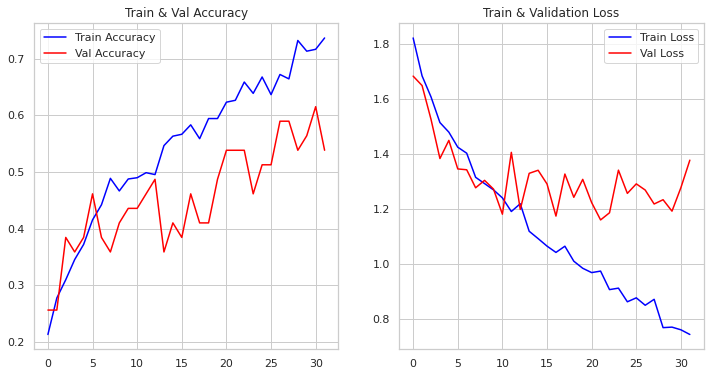

In [31]:
# 학습 결과를 시각화
plot_accuracy_and_loss(history)

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Find the epoch with the highest validation accuracy
best_epoch = val_accuracy.index(max(val_accuracy)) + 1  # Add 1 because epochs are 1-indexed

print(f"Best Accuracy: {accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")
print(f"Best Validation Accuracy: {val_accuracy[best_epoch-1]:.4f} at Epoch {best_epoch}")

Best Accuracy: 0.7167 at Epoch 31
Best Validation Accuracy: 0.6154 at Epoch 31


## W&B Sweeper

In [33]:
import wandb
from wandb.keras import WandbCallback


sweep_config = {
    "name": experiment_name,
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

def train():
    default_config = {
        "input" : (224, 224, 3),
        "num_classes" : 6,
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config=default_config)
    config = wandb.config


    # 모델 생성 및 컴파일
    CNN_V3_model = CNN_V3()
    CNN_V3_model.compile(optimizer=config.optimizer,
                  loss=config.loss,
                  metrics=config.metrics)

    # 모델 학습
    model.fit(train_datagen, 
              epochs=config.epoch,
              validation_data=val_datagen,
              callbacks=[WandbCallback()])

    # 모델 평가
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

    # 결과 로깅
    wandb.log({"Test Accuracy": test_accuracy, "Test Loss": test_loss})

    
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "3like4",
                       project = "Jellyfish_project")

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)

Create sweep with ID: xgoo5qos
Sweep URL: https://wandb.ai/3like4/Jellyfish_project/sweeps/xgoo5qos


wandb: Agent Starting Run: xaqa0agx with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.032313900175439406


Epoch 1/10
45/45 [==============================] - 9s 196ms/step - loss: 0.2206 - accuracy: 0.9200 - val_loss: 2.2093 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best)... Done. 4.1s


Epoch 2/10
45/45 [==============================] - 9s 195ms/step - loss: 0.1604 - accuracy: 0.9533 - val_loss: 2.4647 - val_accuracy: 0.5897
Epoch 3/10
45/45 [==============================] - 9s 196ms/step - loss: 0.1379 - accuracy: 0.9567 - val_loss: 2.6051 - val_accuracy: 0.5385
Epoch 4/10
45/45 [==============================] - 9s 194ms/step - loss: 0.2132 - accuracy: 0.9356 - val_loss: 2.4516 - val_accuracy: 0.6410
Epoch 5/10
45/45 [==============================] - 9s 194ms/step - loss: 0.2309 - accuracy: 0.9289 - val_loss: 2.3159 - val_accuracy: 0.5641
Epoch 6/10
45/45 [==============================] - 9s 197ms/step - loss: 0.1081 - accuracy: 0.9633 - val_loss: 2.4885 - val_accuracy: 0.5897
Epoch 7/10
45/45 [==============================] - 9s 196ms/step - loss: 0.1645 - accuracy: 0.9500 - val_loss: 2.1669 - val_accuracy: 0.4872
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best)... Done. 4.7s


Epoch 8/10
45/45 [==============================] - 9s 205ms/step - loss: 0.2405 - accuracy: 0.9244 - val_loss: 2.1311 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best)... Done. 7.2s


Epoch 9/10
45/45 [==============================] - 9s 201ms/step - loss: 0.2143 - accuracy: 0.9300 - val_loss: 2.0991 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165527-xaqa0agx/files/model-best)... Done. 4.9s


Epoch 10/10
45/45 [==============================] - 9s 203ms/step - loss: 0.2860 - accuracy: 0.9011 - val_loss: 2.6438 - val_accuracy: 0.5128
2/2 - 0s - loss: 1.7217 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▃▇▇▅▄█▇▄▄▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▅▃▂▅▆▁▃▆▅█
val_accuracy,▆▆▃█▅▆▁▆▃▂
val_loss,▂▆█▆▄▆▂▁▁█
Test Accuracy,0.575
Test Loss,1.72174
accuracy,0.90111
best_epoch,8


wandb: Agent Starting Run: y70nhzq8 with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.03822551482532165


Epoch 1/5
45/45 [==============================] - 9s 197ms/step - loss: 0.2028 - accuracy: 0.9367 - val_loss: 2.2762 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165810-y70nhzq8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165810-y70nhzq8/files/model-best)... Done. 8.3s


Epoch 2/5
45/45 [==============================] - 9s 201ms/step - loss: 0.1716 - accuracy: 0.9478 - val_loss: 2.3858 - val_accuracy: 0.5385
Epoch 3/5
45/45 [==============================] - 9s 196ms/step - loss: 0.1257 - accuracy: 0.9667 - val_loss: 2.4986 - val_accuracy: 0.6410
Epoch 4/5
45/45 [==============================] - 9s 197ms/step - loss: 0.1725 - accuracy: 0.9444 - val_loss: 2.5809 - val_accuracy: 0.5897
Epoch 5/5
45/45 [==============================] - 9s 198ms/step - loss: 0.1980 - accuracy: 0.9322 - val_loss: 2.2647 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165810-y70nhzq8/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165810-y70nhzq8/files/model-best)... Done. 3.7s


2/2 - 0s - loss: 1.4619 - accuracy: 0.6500


Test Accuracy,▁
Test Loss,▁
accuracy,▂▄█▃▁
epoch,▁▃▅▆█
loss,█▅▁▅█
val_accuracy,▆▁█▅▆
val_loss,▁▄▆█▁
Test Accuracy,0.65
Test Loss,1.46194
accuracy,0.93222
best_epoch,4


wandb: Agent Starting Run: rks64q29 with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.09788149311789236


Epoch 1/8
45/45 [==============================] - 9s 196ms/step - loss: 0.1369 - accuracy: 0.9656 - val_loss: 2.5651 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best)... Done. 9.3s


Epoch 2/8
45/45 [==============================] - 9s 200ms/step - loss: 0.1239 - accuracy: 0.9578 - val_loss: 2.3449 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best)... Done. 8.6s


Epoch 3/8
45/45 [==============================] - 9s 204ms/step - loss: 0.1520 - accuracy: 0.9467 - val_loss: 2.1719 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best)... Done. 6.4s


Epoch 4/8
45/45 [==============================] - 9s 207ms/step - loss: 0.1161 - accuracy: 0.9589 - val_loss: 2.0809 - val_accuracy: 0.6923
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_165943-rks64q29/files/model-best)... Done. 5.5s


Epoch 5/8
45/45 [==============================] - 9s 202ms/step - loss: 0.0866 - accuracy: 0.9744 - val_loss: 2.3438 - val_accuracy: 0.6667
Epoch 6/8
45/45 [==============================] - 9s 199ms/step - loss: 0.1537 - accuracy: 0.9567 - val_loss: 2.4280 - val_accuracy: 0.6667
Epoch 7/8
45/45 [==============================] - 9s 195ms/step - loss: 0.1414 - accuracy: 0.9567 - val_loss: 2.3906 - val_accuracy: 0.5897s: 0.1
Epoch 8/8
45/45 [==============================] - 9s 195ms/step - loss: 0.1298 - accuracy: 0.9567 - val_loss: 2.5407 - val_accuracy: 0.5641
2/2 - 0s - loss: 1.9427 - accuracy: 0.6000


Test Accuracy,▁
Test Loss,▁
accuracy,▆▄▁▄█▄▄▄
epoch,▁▂▃▄▅▆▇█
loss,▆▅█▄▁█▇▆
val_accuracy,▇▅▇█▇▇▂▁
val_loss,█▅▂▁▅▆▅█
Test Accuracy,0.6
Test Loss,1.94266
accuracy,0.95667
best_epoch,3


wandb: Agent Starting Run: ajuoov0b with config:
wandb: 	epoch: 9
wandb: 	learning_rate: 0.03569970783145227


Epoch 1/9
45/45 [==============================] - 9s 198ms/step - loss: 0.1355 - accuracy: 0.9544 - val_loss: 2.8700 - val_accuracy: 0.58978 - accuracy: 
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best)... Done. 6.5s


Epoch 2/9
45/45 [==============================] - 9s 205ms/step - loss: 0.1561 - accuracy: 0.9456 - val_loss: 2.7063 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best)... Done. 7.1s


Epoch 3/9
45/45 [==============================] - 9s 207ms/step - loss: 0.1558 - accuracy: 0.9478 - val_loss: 2.8759 - val_accuracy: 0.5897
Epoch 4/9
45/45 [==============================] - 9s 198ms/step - loss: 0.2029 - accuracy: 0.9411 - val_loss: 2.4462 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best)... Done. 3.7s


Epoch 5/9
45/45 [==============================] - 9s 207ms/step - loss: 0.2306 - accuracy: 0.9300 - val_loss: 2.0417 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170216-ajuoov0b/files/model-best)... Done. 8.3s


Epoch 6/9
45/45 [==============================] - 9s 201ms/step - loss: 0.1973 - accuracy: 0.9456 - val_loss: 2.0444 - val_accuracy: 0.5897
Epoch 7/9
45/45 [==============================] - 9s 196ms/step - loss: 0.1461 - accuracy: 0.9578 - val_loss: 2.6759 - val_accuracy: 0.6410
Epoch 8/9
45/45 [==============================] - 9s 196ms/step - loss: 0.2051 - accuracy: 0.9478 - val_loss: 2.3572 - val_accuracy: 0.5897
Epoch 9/9
45/45 [==============================] - 9s 196ms/step - loss: 0.2109 - accuracy: 0.9333 - val_loss: 2.5244 - val_accuracy: 0.6154
2/2 - 0s - loss: 2.0033 - accuracy: 0.6500


Test Accuracy,▁
Test Loss,▁
accuracy,▇▅▅▄▁▅█▅▂
epoch,▁▂▃▄▅▅▆▇█
loss,▁▃▂▆█▆▂▆▇
val_accuracy,▁▅▁▅█▁█▁▅
val_loss,█▇█▄▁▁▆▄▅
Test Accuracy,0.65
Test Loss,2.00332
accuracy,0.93333
best_epoch,4


wandb: Agent Starting Run: vhqd7clh with config:
wandb: 	epoch: 8
wandb: 	learning_rate: 0.028179231850997945


Epoch 1/8
45/45 [==============================] - 9s 197ms/step - loss: 0.2246 - accuracy: 0.9344 - val_loss: 2.3549 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best)... Done. 8.2s


Epoch 2/8
45/45 [==============================] - 9s 200ms/step - loss: 0.1928 - accuracy: 0.9389 - val_loss: 2.2543 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best)... Done. 3.7s


Epoch 3/8
45/45 [==============================] - 9s 206ms/step - loss: 0.1576 - accuracy: 0.9478 - val_loss: 2.4322 - val_accuracy: 0.6410
Epoch 4/8
45/45 [==============================] - 9s 195ms/step - loss: 0.1328 - accuracy: 0.9544 - val_loss: 2.2177 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170446-vhqd7clh/files/model-best)... Done. 4.1s


Epoch 5/8
45/45 [==============================] - 9s 203ms/step - loss: 0.0973 - accuracy: 0.9722 - val_loss: 2.4890 - val_accuracy: 0.6667
Epoch 6/8
45/45 [==============================] - 9s 197ms/step - loss: 0.0704 - accuracy: 0.9733 - val_loss: 2.5587 - val_accuracy: 0.5897
Epoch 7/8
45/45 [==============================] - 9s 199ms/step - loss: 0.1137 - accuracy: 0.9556 - val_loss: 2.4540 - val_accuracy: 0.6154
Epoch 8/8
45/45 [==============================] - 9s 198ms/step - loss: 0.0906 - accuracy: 0.9722 - val_loss: 2.6458 - val_accuracy: 0.6154
2/2 - 0s - loss: 2.2473 - accuracy: 0.6500


Test Accuracy,▁
Test Loss,▁
accuracy,▁▂▃▅██▅█
epoch,▁▂▃▄▅▆▇█
loss,█▇▅▄▂▁▃▂
val_accuracy,▁▃▆██▁▃▃
val_loss,▃▂▅▁▅▇▅█
Test Accuracy,0.65
Test Loss,2.24728
accuracy,0.97222
best_epoch,3


wandb: Agent Starting Run: l63u36ol with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.012540105146412465


Epoch 1/7
45/45 [==============================] - 9s 201ms/step - loss: 0.1257 - accuracy: 0.9522 - val_loss: 3.0367 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best)... Done. 7.3s


Epoch 2/7
45/45 [==============================] - 9s 200ms/step - loss: 0.1186 - accuracy: 0.9667 - val_loss: 2.5155 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best)... Done. 5.2s


Epoch 3/7
45/45 [==============================] - 9s 205ms/step - loss: 0.2415 - accuracy: 0.9367 - val_loss: 3.2469 - val_accuracy: 0.5897
Epoch 4/7
45/45 [==============================] - 9s 201ms/step - loss: 0.1560 - accuracy: 0.9500 - val_loss: 2.4325 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170701-l63u36ol/files/model-best)... Done. 3.8s


Epoch 5/7
45/45 [==============================] - 9s 205ms/step - loss: 0.1308 - accuracy: 0.9611 - val_loss: 2.4342 - val_accuracy: 0.6410
Epoch 6/7
45/45 [==============================] - 9s 197ms/step - loss: 0.1527 - accuracy: 0.9478 - val_loss: 2.4890 - val_accuracy: 0.64101s - loss: 0.1270 
Epoch 7/7
45/45 [==============================] - 9s 198ms/step - loss: 0.0979 - accuracy: 0.9689 - val_loss: 2.6244 - val_accuracy: 0.6410
2/2 - 0s - loss: 1.8718 - accuracy: 0.7000


Test Accuracy,▁
Test Loss,▁
accuracy,▄█▁▄▆▃█
epoch,▁▂▃▅▆▇█
loss,▂▂█▄▃▄▁
val_accuracy,▁▆▁█▆▆▆
val_loss,▆▂█▁▁▁▃
Test Accuracy,0.7
Test Loss,1.87179
accuracy,0.96889
best_epoch,3


wandb: Agent Starting Run: j9nts4el with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.05598625506405689


Epoch 1/5
45/45 [==============================] - 9s 199ms/step - loss: 0.0854 - accuracy: 0.9711 - val_loss: 2.8707 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170909-j9nts4el/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170909-j9nts4el/files/model-best)... Done. 8.8s


Epoch 2/5
45/45 [==============================] - 10s 205ms/step - loss: 0.1426 - accuracy: 0.9522 - val_loss: 3.0669 - val_accuracy: 0.6410
Epoch 3/5
45/45 [==============================] - 9s 198ms/step - loss: 0.0867 - accuracy: 0.9700 - val_loss: 2.9788 - val_accuracy: 0.6154
Epoch 4/5
45/45 [==============================] - 9s 200ms/step - loss: 0.0578 - accuracy: 0.9778 - val_loss: 2.9012 - val_accuracy: 0.5897
Epoch 5/5
45/45 [==============================] - 9s 197ms/step - loss: 0.1029 - accuracy: 0.9711 - val_loss: 2.8051 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_170909-j9nts4el/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_170909-j9nts4el/files/model-best)... Done. 3.8s


2/2 - 0s - loss: 1.9349 - accuracy: 0.6000


Test Accuracy,▁
Test Loss,▁
accuracy,▆▁▆█▆
epoch,▁▃▅▆█
loss,▃█▃▁▅
val_accuracy,▅█▅▁█
val_loss,▃█▆▄▁
Test Accuracy,0.6
Test Loss,1.93495
accuracy,0.97111
best_epoch,4


wandb: Agent Starting Run: m7ixbktu with config:
wandb: 	epoch: 10
wandb: 	learning_rate: 0.04193015178460401


Epoch 1/10
45/45 [==============================] - 9s 199ms/step - loss: 0.0965 - accuracy: 0.9644 - val_loss: 2.6971 - val_accuracy: 0.5897
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171047-m7ixbktu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171047-m7ixbktu/files/model-best)... Done. 5.6s


Epoch 2/10
45/45 [==============================] - 9s 204ms/step - loss: 0.1072 - accuracy: 0.9633 - val_loss: 2.9108 - val_accuracy: 0.5897
Epoch 3/10
45/45 [==============================] - 9s 200ms/step - loss: 0.1509 - accuracy: 0.9500 - val_loss: 2.4375 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171047-m7ixbktu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171047-m7ixbktu/files/model-best)... Done. 6.4s


Epoch 4/10
45/45 [==============================] - 9s 202ms/step - loss: 0.2492 - accuracy: 0.9344 - val_loss: 2.4590 - val_accuracy: 0.6410
Epoch 5/10
45/45 [==============================] - 9s 200ms/step - loss: 0.1990 - accuracy: 0.9367 - val_loss: 2.7641 - val_accuracy: 0.5385
Epoch 6/10
45/45 [==============================] - 9s 199ms/step - loss: 0.1642 - accuracy: 0.9500 - val_loss: 3.0962 - val_accuracy: 0.5641
Epoch 7/10
45/45 [==============================] - 9s 199ms/step - loss: 0.1550 - accuracy: 0.9467 - val_loss: 2.9249 - val_accuracy: 0.5897
Epoch 8/10
45/45 [==============================] - 9s 197ms/step - loss: 0.1464 - accuracy: 0.9511 - val_loss: 2.8035 - val_accuracy: 0.6410
Epoch 9/10
45/45 [==============================] - 9s 199ms/step - loss: 0.1675 - accuracy: 0.9467 - val_loss: 2.7175 - val_accuracy: 0.6410
Epoch 10/10
45/45 [==============================] - 9s 196ms/step - loss: 0.2195 - accuracy: 0.9311 - val_loss: 2.6064 - val_accuracy: 0.6154
2/2 -

Test Accuracy,▁
Test Loss,▁
accuracy,██▅▂▂▅▄▅▄▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▃█▆▄▄▃▄▇
val_accuracy,▅▅▆█▁▃▅██▆
val_loss,▄▆▁▁▄█▆▅▄▃
Test Accuracy,0.675
Test Loss,1.6707
accuracy,0.93111
best_epoch,2


wandb: Agent Starting Run: n2scccdp with config:
wandb: 	epoch: 5
wandb: 	learning_rate: 0.029894913995007277


Epoch 1/5
45/45 [==============================] - 9s 197ms/step - loss: 0.1981 - accuracy: 0.9344 - val_loss: 2.6984 - val_accuracy: 0.6154
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171309-n2scccdp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171309-n2scccdp/files/model-best)... Done. 6.6s


Epoch 2/5
45/45 [==============================] - 9s 203ms/step - loss: 0.1257 - accuracy: 0.9600 - val_loss: 2.3089 - val_accuracy: 0.6410
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171309-n2scccdp/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171309-n2scccdp/files/model-best)... Done. 5.9s


Epoch 3/5
45/45 [==============================] - 9s 204ms/step - loss: 0.0967 - accuracy: 0.9644 - val_loss: 2.8943 - val_accuracy: 0.5897
Epoch 4/5
45/45 [==============================] - 9s 195ms/step - loss: 0.0940 - accuracy: 0.9689 - val_loss: 2.4473 - val_accuracy: 0.6154
Epoch 5/5
45/45 [==============================] - 9s 197ms/step - loss: 0.0712 - accuracy: 0.9733 - val_loss: 2.6109 - val_accuracy: 0.6410
2/2 - 0s - loss: 2.1441 - accuracy: 0.5750


Test Accuracy,▁
Test Loss,▁
accuracy,▁▆▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▅█▁▅█
val_loss,▆▁█▃▅
Test Accuracy,0.575
Test Loss,2.14408
accuracy,0.97333
best_epoch,1


wandb: Agent Starting Run: l2mjsqfk with config:
wandb: 	epoch: 7
wandb: 	learning_rate: 0.08870058047802618


Epoch 1/7
45/45 [==============================] - 9s 199ms/step - loss: 0.0538 - accuracy: 0.9778 - val_loss: 2.9842 - val_accuracy: 0.6667
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171451-l2mjsqfk/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171451-l2mjsqfk/files/model-best)... Done. 7.9s


Epoch 2/7
45/45 [==============================] - 9s 200ms/step - loss: 0.0588 - accuracy: 0.9856 - val_loss: 3.1603 - val_accuracy: 0.6154
Epoch 3/7
45/45 [==============================] - 9s 197ms/step - loss: 0.0601 - accuracy: 0.9767 - val_loss: 3.7554 - val_accuracy: 0.5897
Epoch 4/7
45/45 [==============================] - 9s 197ms/step - loss: 0.1214 - accuracy: 0.9522 - val_loss: 3.2179 - val_accuracy: 0.5641
Epoch 5/7
45/45 [==============================] - 9s 196ms/step - loss: 0.0767 - accuracy: 0.9722 - val_loss: 3.1265 - val_accuracy: 0.5385
Epoch 6/7
45/45 [==============================] - 9s 201ms/step - loss: 0.0822 - accuracy: 0.9744 - val_loss: 3.1464 - val_accuracy: 0.6154
Epoch 7/7
45/45 [==============================] - 9s 197ms/step - loss: 0.1708 - accuracy: 0.9578 - val_loss: 2.7935 - val_accuracy: 0.5385
INFO:tensorflow:Assets written to: /aiffel/aiffel/jellyfish/wandb/run-20240110_171451-l2mjsqfk/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/jellyfish/wandb/run-20240110_171451-l2mjsqfk/files/model-best)... Done. 4.4s


2/2 - 0s - loss: 1.9960 - accuracy: 0.6250


Test Accuracy,▁
Test Loss,▁
accuracy,▆█▆▁▅▆▂
epoch,▁▂▃▅▆▇█
loss,▁▁▁▅▂▃█
val_accuracy,█▅▄▂▁▅▁
val_loss,▂▄█▄▃▄▁
Test Accuracy,0.625
Test Loss,1.99595
accuracy,0.95778
best_epoch,6
